In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
sample_path = '../../samples/sample_1500_2p8M_jets.pkl'
sample = pd.read_pickle(sample_path)

In [3]:
sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,target
1046823,1765.118652,0.765842,36.0,0.041832,0.226598,0.174245,2.0,1.0,0.002186,0.000002,0.0
5717242,1605.052368,-0.346835,14.0,0.020056,0.105758,-0.355126,2.0,1.0,0.011307,0.000004,0.0
454956,1673.008789,0.259815,6.0,0.008405,0.096004,-0.586819,2.0,1.0,0.013519,0.000007,0.0
2294496,1725.240845,-0.696387,16.0,0.029819,0.157534,-0.262760,1.0,1.0,0.001749,0.000001,0.0
3708534,1508.333740,-0.228486,15.0,0.027709,0.214327,-0.154856,1.0,1.0,0.020987,0.000005,0.0


In [23]:
features = [*sample.columns[:6]]
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-0.8, 0.7, 61), 
}

In [7]:
features

['jet_pt',
 'jet_eta',
 'jet_nTracks',
 'jet_trackWidth',
 'jet_trackC1',
 'jet_trackBDT']

In [8]:
sample_quark = sample[sample['target']==0]
sample_gluon = sample[sample['target']==1]

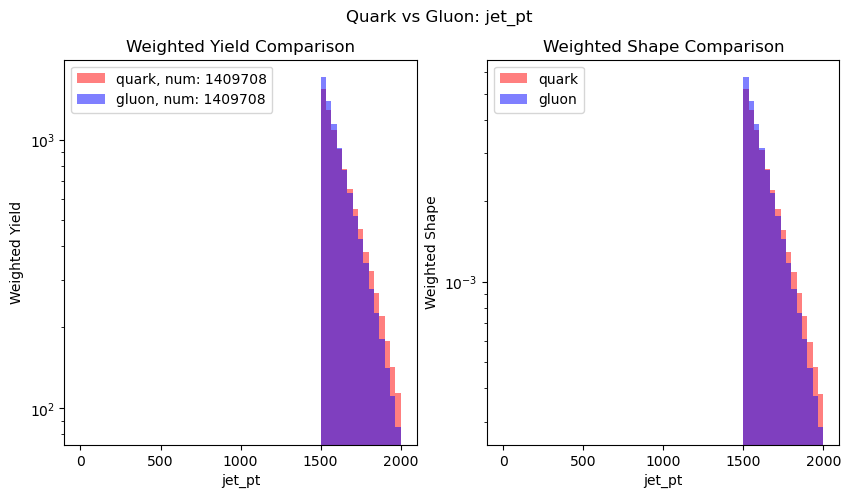

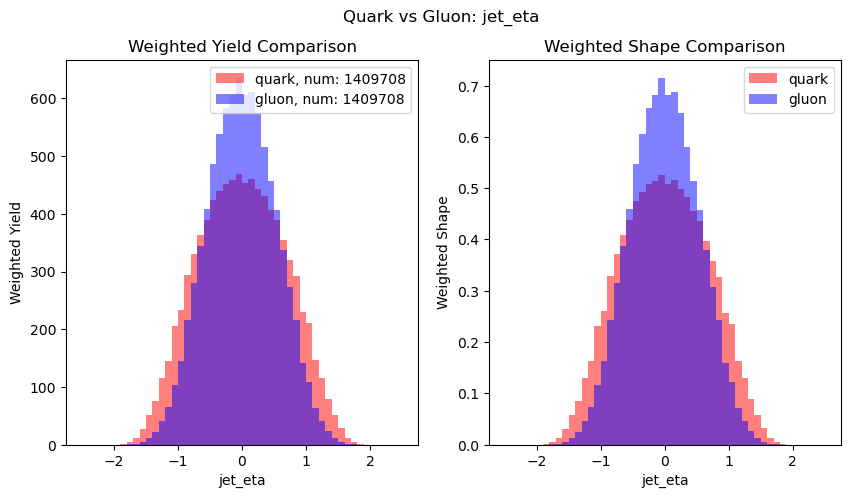

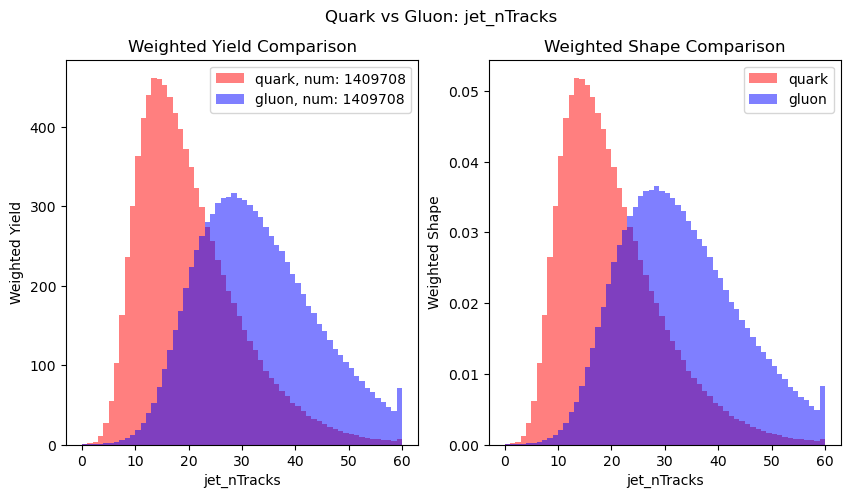

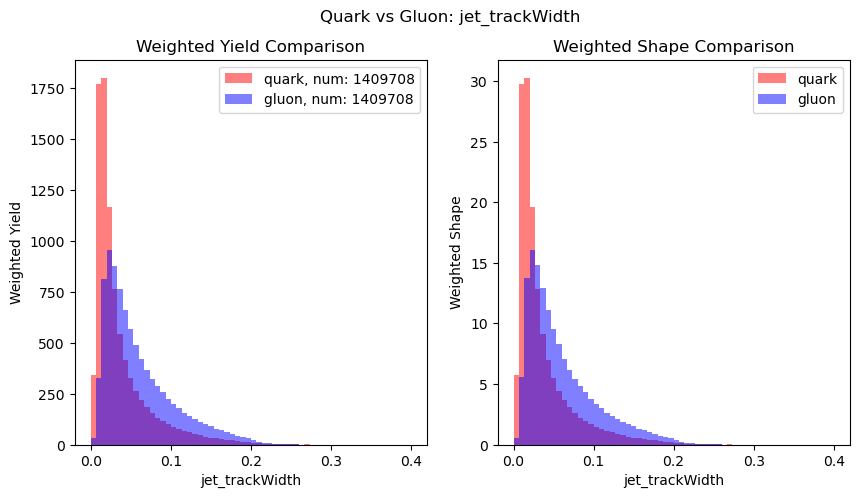

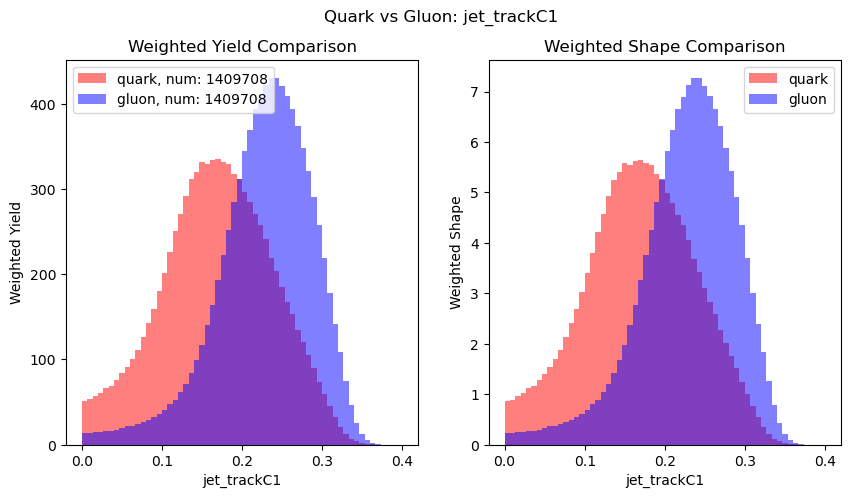

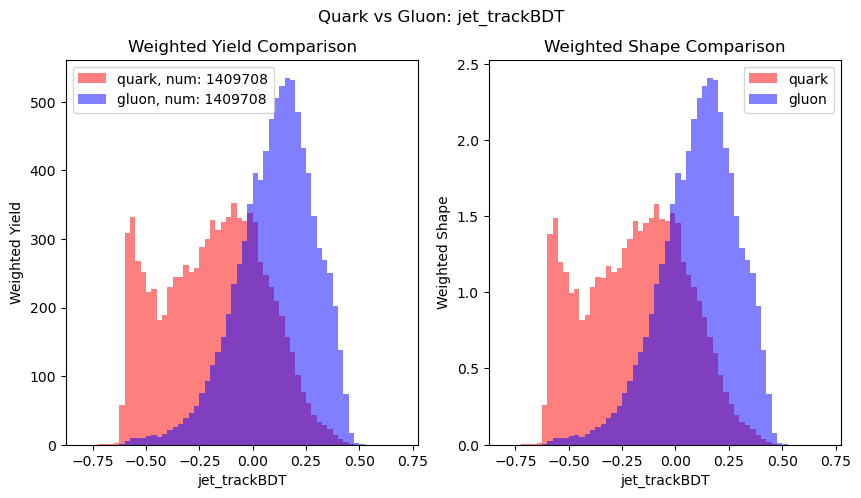

In [49]:
for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_quark[feature_name], bins = custom_bins, weights = sample_quark['event_weight'], label = f'quark, num: {len(sample_quark)}', color='red', alpha = 0.5)
    ax0.hist(sample_gluon[feature_name], bins = custom_bins, weights = sample_gluon['event_weight'], label = f'gluon, num: {len(sample_gluon)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_quark[feature_name], bins = custom_bins, weights = sample_quark['event_weight'], label = 'quark', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_gluon[feature_name], bins = custom_bins, weights = sample_gluon['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Quark vs Gluon: {feature_name}")

    plt.plot()

In [29]:
np.min(sample_quark['jet_trackC1'])
np.sum(sample_quark['jet_trackC1'] == -1 )
np.min(sample_quark['jet_trackWidth'])
np.sum(sample_quark['jet_trackWidth'] == -1 )


238

In [37]:
sample[sample['jet_trackWidth'] == -1]

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,target
3366041,1730.550659,0.411281,0.0,-1.0,-1.0,-0.398841,2.0,1.0,0.002898,2.166164e-06,0.0
1941516,1889.180908,-0.755650,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.001909,3.380486e-06,0.0
2780266,1908.018066,-0.965470,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.001901,3.969440e-06,0.0
3238219,1591.837646,-1.010071,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.002112,7.070265e-07,0.0
797134,1879.337402,-0.753329,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.001675,2.966270e-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1200791,1525.425537,-0.229707,0.0,-1.0,-1.0,-0.385599,21.0,1.0,0.012207,3.113705e-06,1.0
6165343,1530.150391,0.782221,0.0,-1.0,-1.0,-0.382532,21.0,1.0,0.005954,1.518620e-06,1.0
3318315,1629.400513,-0.141506,0.0,-1.0,-1.0,-0.396995,21.0,1.0,0.002395,1.048447e-06,1.0
1036437,1507.558594,-0.366789,0.0,-1.0,-1.0,-0.383978,21.0,1.0,0.001599,3.554924e-07,1.0


In [38]:
sample[sample['jet_nTracks'] == 0]

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,target
3366041,1730.550659,0.411281,0.0,-1.0,-1.0,-0.398841,2.0,1.0,0.002898,2.166164e-06,0.0
1941516,1889.180908,-0.755650,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.001909,3.380486e-06,0.0
2780266,1908.018066,-0.965470,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.001901,3.969440e-06,0.0
3238219,1591.837646,-1.010071,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.002112,7.070265e-07,0.0
797134,1879.337402,-0.753329,0.0,-1.0,-1.0,-0.396995,2.0,1.0,0.001675,2.966270e-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1200791,1525.425537,-0.229707,0.0,-1.0,-1.0,-0.385599,21.0,1.0,0.012207,3.113705e-06,1.0
6165343,1530.150391,0.782221,0.0,-1.0,-1.0,-0.382532,21.0,1.0,0.005954,1.518620e-06,1.0
3318315,1629.400513,-0.141506,0.0,-1.0,-1.0,-0.396995,21.0,1.0,0.002395,1.048447e-06,1.0
1036437,1507.558594,-0.366789,0.0,-1.0,-1.0,-0.383978,21.0,1.0,0.001599,3.554924e-07,1.0


[]

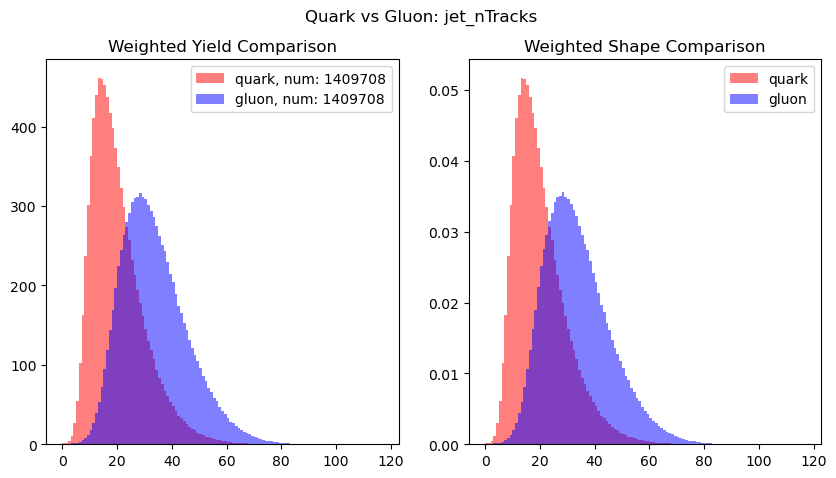

In [48]:
feature_name = features[2]
n_bins = np.linspace(0, np.max(sample['jet_nTracks']), int(np.max(sample['jet_nTracks'])+1))
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
ax0.hist(sample_quark[feature_name], bins = n_bins, weights = sample_quark['event_weight'], label = f'quark, num: {len(sample_quark)}', color='red', alpha = 0.5)
ax0.hist(sample_gluon[feature_name], bins = n_bins, weights = sample_gluon['event_weight'], label = f'gluon, num: {len(sample_gluon)}', color='blue', alpha = 0.5)
ax0.legend()
ax0.set_title(f"Weighted Yield Comparison")

if feature_name == 'jet_pt':
    ax0.set_yscale('log')

ax1.hist(sample_quark[feature_name], bins = n_bins, weights = sample_quark['event_weight'], label = 'quark', color='red', alpha = 0.5, density=True)
ax1.hist(sample_gluon[feature_name], bins = n_bins, weights = sample_gluon['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
ax1.legend()
ax1.set_title(f"Weighted Shape Comparison")
if feature_name == 'jet_pt':
    ax1.set_yscale('log')
fig.suptitle(f"Quark vs Gluon: {feature_name}")

plt.plot()

In [ ]:
np